In [50]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import time
import numpy as np
import matplotlib.pyplot as plt

In [46]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        '''
        resnet残差学习模块
        Input:
        in_planes -- 输入的通道数
        planes -- 输出的通道数
        stride -- 调节卷积中的stride参数，用于保证tensor的维度匹配
        
        Output:
        model        
        '''
        super(BasicBlock, self).__init__()
        # (1) Conv2D(3×3，planes),same, 【stride(1)或stride(2)】 BN
        # (2) Conv2D(3×3，planes),same, BN
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # 当stride为2时，需要增加一个1*1卷积实现维度匹配
        self.shortcut = nn.Sequential()
        if stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        '''
        此block被循环了多少次
        '''
        strides = [stride] + [1]*(num_blocks - 1) #除了第一个stride可能为2，其余均为1
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes 
        return nn.Sequential(*layers) #将layer中的元素顺序取出，作为Sequential的值


    def forward(self, x):
        x = self.conv1(x) # [B,3,H,W] to [B,64,H/2,W/2]
        x = self.bn1(x)   # [B,64,H/2,W/2] to [B,64,H/2,W/2]
        x = self.relu(x)  # [B,64,H/2,W/2] to [B,64,H/2,W/2]
        x = self.maxpool(x) # [B,64,H/4,W/4] to [B,64,H/4,W/4]
        x = self.layer1(x) # [B,64,H/4,W/4] to [B,64,H/4,W/4]
        x = self.layer2(x) # [B,64,H/4,W/4] to [B,128,H/8,W/8]
        x = self.layer3(x) # [B,128,H/8,W/8] to [B,256,H/16,W/16]
        out = self.layer4(x) # [B,256,H/16,W/16] to [B,512,H/32,W/32]
        return out

def ResNet34():
    '''
    Input:[B,3,H,W]
    Output:[B,512,H/8,W/8]
    '''
    return ResNet(BasicBlock, [3, 4, 6, 3])

class Conv(nn.Module):
    '''
    Input:[B,c1,H,W]
    Output:[B,c2,H,W]
    '''
    def __init__(self, c1, c2, k, s=1, p=0, d=1, g=1, act=True):
        super(Conv, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(c1, c2, k, stride=s, padding=p, dilation=d, groups=g),
            nn.BatchNorm2d(c2),
            nn.LeakyReLU(0.1, inplace=True) if act else nn.Identity()
        )

    def forward(self, x):
        return self.convs(x)


class SPP(nn.Module):
    """
        Spatial Pyramid Pooling
    """
    def __init__(self):
        super(SPP, self).__init__()

    def forward(self, x):
        """
        Input:
            x: (Tensor) -> [B, C, H, W]
        Output:
            y: (Tensor) -> [B, 4C, H, W]
        """
        x_1 = torch.nn.functional.max_pool2d(x, 5, stride=1, padding=2)
        x_2 = torch.nn.functional.max_pool2d(x, 9, stride=1, padding=4)
        x_3 = torch.nn.functional.max_pool2d(x, 13, stride=1, padding=6)
        y = torch.cat([x, x_1, x_2, x_3], dim=1)

        return y
    
class MSEWithLogitsLoss(nn.Module):
    def __init__(self, ):
        super(MSEWithLogitsLoss, self).__init__()

    def forward(self, logits, target):
        inputs = torch.clamp(torch.sigmoid(logits), min=1e-4, max=1.0 - 1e-4)

        pos_id = (target==1.0).float()
        neg_id = (target==0.0).float()
        pos_loss = pos_id * (inputs - target)**2
        neg_loss = neg_id * (inputs)**2
        loss = 5.0*pos_loss + 1.0*neg_loss

        return loss

def generate_dxdywh(gt_label, w, h, s):
    x, y, bw, bh = gt_label[1:]  # 提取x,y,w,h（这四个数都经过了归一化）
    # 计算边界框的中心点
    c_x = x * w  # 乘以图像宽度得到真实坐标
    c_y = y * h  # 乘以图像高度得到真实坐标
    box_w = bw * w  # 乘以图像宽度得到框的真实宽度
    box_h = bh * h  # 乘以图像高度得到框的真实高度

    if box_w < 1e-4 or box_h < 1e-4:
        # print('Not a valid data !!!')
        return False    

    # 计算中心点所在的网格坐标
    c_x_s = c_x / s
    c_y_s = c_y / s
    grid_x = int(c_x_s)
    grid_y = int(c_y_s)
    # 计算中心点偏移量和宽高的标签
    tx = c_x_s - grid_x
    ty = c_y_s - grid_y
    tw = np.log(box_w)
    th = np.log(box_h)
    # 计算边界框位置参数的损失权重
    weight = 2.0 - (box_w / w) * (box_h / h)

    return grid_x, grid_y, tx, ty, tw, th, weight


def gt_creator(input_size, stride, label_lists=[]):
    # 必要的参数
    batch_size = len(label_lists)
    w = input_size
    h = input_size
    ws = w // stride
    hs = h // stride
    s = stride
    gt_tensor = np.zeros([batch_size, hs, ws, 1+1+4+1])

    # 制作训练标签
    for batch_index in range(batch_size):
        for gt_label in label_lists[batch_index]:
            gt_class = int(gt_label[0])
            result = generate_dxdywh(gt_label, w, h, s)
            if result:
                grid_x, grid_y, tx, ty, tw, th, weight = result

                if grid_x < gt_tensor.shape[2] and grid_y < gt_tensor.shape[1]:
                    gt_tensor[batch_index, grid_y, grid_x, 0] = 1.0
                    gt_tensor[batch_index, grid_y, grid_x, 1] = gt_class
                    gt_tensor[batch_index, grid_y, grid_x, 2:6] = np.array([tx, ty, tw, th])
                    gt_tensor[batch_index, grid_y, grid_x, 6] = weight


    gt_tensor = gt_tensor.reshape(batch_size, -1, 1+1+4+1)

    return torch.from_numpy(gt_tensor).float()


def compute_loss(pred_conf, pred_cls, pred_txtytwth, targets):
    batch_size = pred_conf.size(0)
    # 损失函数
    conf_loss_function = MSEWithLogitsLoss()
    cls_loss_function = nn.CrossEntropyLoss(reduction='none')
    txty_loss_function = nn.BCEWithLogitsLoss(reduction='none')
    twth_loss_function = nn.MSELoss(reduction='none')

    # 预测
    pred_conf = pred_conf[:, :, 0]           # [B, (H/32)*(W/32),]
    pred_cls = pred_cls.permute(0, 2, 1)     # [B, C, (H/32)*(W/32)]
    pred_txty = pred_txtytwth[:, :, :2]      # [B, (H/32)*(W/32), 2]
    pred_twth = pred_txtytwth[:, :, 2:]      # [B, (H/32)*(W/32), 2]
    
    # 标签
    gt_obj = targets[:, :, 0]                  # [B, (H/32)*(W/32),]
    gt_cls = targets[:, :, 1].long()           # [B, (H/32)*(W/32),]
    gt_txty = targets[:, :, 2:4]               # [B, (H/32)*(W/32), 2]
    gt_twth = targets[:, :, 4:6]               # [B, (H/32)*(W/32), 2]
    gt_box_scale_weight = targets[:, :, 6]     # [B, (H/32)*(W/32),]

    batch_size = pred_conf.size(0)
    
    # 置信度损失
    conf_loss = conf_loss_function(pred_conf, gt_obj)
    conf_loss = conf_loss.sum() / batch_size
    
    # 类别损失
    cls_loss = cls_loss_function(pred_cls, gt_cls) * gt_obj
    cls_loss = cls_loss.sum() / batch_size
    
    # 边界框txty的损失
    txty_loss = txty_loss_function(pred_txty, gt_txty).sum(-1) * gt_obj * gt_box_scale_weight
    txty_loss = txty_loss.sum() / batch_size

    # 边界框twth的损失
    twth_loss = twth_loss_function(pred_twth, gt_twth).sum(-1) * gt_obj * gt_box_scale_weight
    twth_loss = twth_loss.sum() / batch_size
    bbox_loss = txty_loss + twth_loss

    # 总的损失
    total_loss = conf_loss + cls_loss + bbox_loss

    return conf_loss, cls_loss, bbox_loss, total_loss

def detection_collate(batch):
    """自定义整理函数，用于处理具有不同数量的相关对象注释（边界框）的图像批次。

    Arguments:
        batch: (tuple) A tuple of tensor images and lists of annotations

    Return:
        A tuple containing:
            1) (tensor) batch of images stacked on their 0 dim
            2) (list of tensors) annotations for a given image are stacked on
                                 0 dim
    """
    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])
        targets.append(torch.FloatTensor(sample[1]))
    return torch.stack(imgs, 0), targets

class myYOLO(nn.Module):
    def __init__(self, S=7, B=2, C=1, num_classes=5, stride=32, conf_thresh=0.01, trainable=True):
        super(myYOLO,self).__init__()
        self.S = S
        self.B = B
        self.C = C
        self.num_classes = num_classes  # 类别数
        self.stride = stride            # 网格最大步长
        self.conf_thresh = conf_thresh  # 得分阈值
        self.trainable = trainable      # 训练标识
        
        # backbone:ResNet34
        '''
        Input: [B,3,H,W]
        Output:[B,512,H/32,W/32]
        '''
        self.backbone = ResNet34()
        
        # neck:SPP
        '''
        Input:[B,512,H/32,W/32]
        Output:[B,512,H/32,W/32]
        '''
        self.neck = nn.Sequential(
            SPP(),  # [B,512,H/32,W/32] to [B,512*4,H/32,W/32]
            Conv(512*4, 512, k=1), # [B,512*4,H/32,W/32] to [B,512,H/32,W/32]
        )

        # detection head
        '''
        Input:[B,512,H/32,W/32]
        Output:[B,512,H/32,W/32]
        '''
        self.convs = nn.Sequential(
            Conv(512, 216, k=1),
            Conv(216, 512, k=3, p=1),
            Conv(512, 216, k=1),
            Conv(216, 512, k=3, p=1)
        )
        
        # pred
        '''
        Input:[B,512,H/32,W/32]
        Output:[B, 1 + self.num_classes + 4, H/32, W/32]
        '''
        self.pred = nn.Conv2d(512, 1 + self.num_classes + 4, 1)
        
        
    def create_grid(self, input_size=224):
        """ 
            用于生成G矩阵，其中每个元素都是特征图上的像素坐标。
        """
        # 输入图像的宽和高
        w, h = input_size, input_size
        # 特征图的宽和高
        ws, hs = w // self.stride, h // self.stride
        # 生成网格的x坐标和y坐标
        grid_y, grid_x = torch.meshgrid([torch.arange(hs), torch.arange(ws)])
        # 将xy两部分的坐标拼起来：[H, W, 2]
        grid_xy = torch.stack([grid_x, grid_y], dim=-1).float()
        # [H, W, 2] -> [HW, 2] -> [HW, 2]
        grid_xy = grid_xy.view(-1, 2).to(self.device)
        
        return grid_xy


    def set_grid(self, input_size=224):
        """
            用于重置G矩阵。
        """
        self.input_size = input_size
        self.grid_cell = self.create_grid(input_size)
        
    def decode_boxes(self, pred):
        """
            将txtytwth转换为常用的x1y1x2y2形式。
        """
        output = torch.zeros_like(pred)
        # 得到所有bbox 的中心点坐标和宽高
        pred[..., :2] = torch.sigmoid(pred[..., :2]) + self.grid_cell
        pred[..., 2:] = torch.exp(pred[..., 2:])

        # 将所有bbox的中心带你坐标和宽高换算成x1y1x2y2形式
        output[..., :2] = pred[..., :2] * self.stride - pred[..., 2:] * 0.5
        output[..., 2:] = pred[..., :2] * self.stride + pred[..., 2:] * 0.5
        
        return output
    
    def nms(self, bboxes, scores):
        """"Pure Python NMS baseline."""
        x1 = bboxes[:, 0]  #xmin
        y1 = bboxes[:, 1]  #ymin
        x2 = bboxes[:, 2]  #xmax
        y2 = bboxes[:, 3]  #ymax

        areas = (x2 - x1) * (y2 - y1)
        order = scores.argsort()[::-1]
        
        keep = []                                             
        while order.size > 0:
            i = order[0]
            keep.append(i)
            # 计算交集的左上角点和右下角点的坐标
            xx1 = np.maximum(x1[i], x1[order[1:]])
            yy1 = np.maximum(y1[i], y1[order[1:]])
            xx2 = np.minimum(x2[i], x2[order[1:]])
            yy2 = np.minimum(y2[i], y2[order[1:]])
            # 计算交集的宽高
            w = np.maximum(1e-10, xx2 - xx1)
            h = np.maximum(1e-10, yy2 - yy1)
            # 计算交集的面积
            inter = w * h

            # 计算交并比
            iou = inter / (areas[i] + areas[order[1:]] - inter)

            # 滤除超过nms阈值的检测框
            inds = np.where(iou <= self.nms_thresh)[0]
            order = order[inds + 1]

        return keep


    def postprocess(self, bboxes, scores):
        """
        Input:
            bboxes: [HxW, 4]
            scores: [HxW, num_classes]
        Output:
            bboxes: [N, 4]
            score:  [N,]
            labels: [N,]
        """

        labels = np.argmax(scores, axis=1)
        scores = scores[(np.arange(scores.shape[0]), labels)]
        
        # threshold
        keep = np.where(scores >= self.conf_thresh)
        bboxes = bboxes[keep]
        scores = scores[keep]
        labels = labels[keep]

        # NMS
        keep = np.zeros(len(bboxes), dtype=np.int)
        for i in range(self.num_classes):
            inds = np.where(labels == i)[0]
            if len(inds) == 0:
                continue
            c_bboxes = bboxes[inds]
            c_scores = scores[inds]
            c_keep = self.nms(c_bboxes, c_scores)
            keep[inds[c_keep]] = 1

        keep = np.where(keep > 0)
        bboxes = bboxes[keep]
        scores = scores[keep]
        labels = labels[keep]

        return bboxes, scores, labels
    

    @torch.no_grad()
    def inference(self, x):
        '''
        用于进行推理
        '''
        # backbone主干网络
        x = self.backbone(x)

        # neck网络
        x = self.neck(x)

        # detection head网络
        x = self.convs(x)

        # 预测层
        pred = self.pred(x)

        # 对pred 的size做一些view调整，便于后续的处理
        # [B, C, H/32, W/32] -> [B, H/32, W/32, C] -> [B, (H/32)*(W/32), C]
        pred = pred.permute(0, 2, 3, 1).contiguous().flatten(1, 2)

        # 从pred中分离出objectness预测、类别class预测、bbox的txtytwth预测  
        # [B, (H/32)*(W/32), 1]
        conf_pred = pred[..., :1]
        # [B, (H/32)*(W/32), num_cls]
        cls_pred = pred[..., 1:1+self.num_classes]
        # [B, (H/32)*(W/32), 4]
        txtytwth_pred = pred[..., 1+self.num_classes:]

        # 推理默认batch是1，不需要用batch这个维度，用[0]将其取走。
        conf_pred = conf_pred[0]            #[(H/32)*(W/32), 1]
        cls_pred = cls_pred[0]              #[(H/32)*(W/32), NC]
        txtytwth_pred = txtytwth_pred[0]    #[(H/32)*(W/32), 4]

        # 每个边界框的得分
        scores = torch.sigmoid(conf_pred) * torch.softmax(cls_pred, dim=-1)
        
        # 解算边界框, 并归一化边界框: [(H/32)*(W/32), 4]
        bboxes = self.decode_boxes(txtytwth_pred) / self.input_size
        bboxes = torch.clamp(bboxes, 0., 1.)
        
        # 将预测放在cpu处理上，以便进行后处理
        scores = scores.to('cpu').numpy()
        bboxes = bboxes.to('cpu').numpy()
        
        # 后处理
        bboxes, scores, labels = self.postprocess(bboxes, scores)

        return bboxes, scores, labels
    
    def forward(self, x, targets):
        if not self.trainable:
            return self.inference(x)
        else:
            # backbone主干网络
            x = self.backbone(x)

            # neck网络
            x = self.neck(x)

            # detection head网络
            x = self.convs(x)

            # 预测层
            pred = self.pred(x)

            # 对pred的size做一些view调整，便于后续的处理
            # [B, C, H/32, W/32] -> [B, H/32, W/32, C] -> [B, (H/32)*(W/32), C]
            pred = pred.permute(0, 2, 3, 1).contiguous().flatten(1, 2)

            # 从pred中分离出objectness预测、类别class预测、bbox的txtytwth预测  
            # [B, (H/32)*(W/32), 1]
            conf_pred = pred[..., :1]
            # [B, (H/32)*(W/32), num_cls]
            cls_pred = pred[..., 1:1+self.num_classes]
            # [B, (H/32)*(W/32), 4]
            txtytwth_pred = pred[..., 1+self.num_classes:]

            # 计算损失
            (
                conf_loss,
                cls_loss,
                bbox_loss,
                total_loss
            ) = compute_loss(pred_conf=conf_pred, 
                             pred_cls=cls_pred,
                             pred_txtytwth=txtytwth_pred,
                             targets=targets
                             )

            return conf_loss, cls_loss, bbox_loss, total_loss

In [11]:
IMSIZE = 224  
myYOLO = myYOLO().cuda()  # 实例化模型并将其移至GPU
# targets = torch.zeros(1, 28*28, 7).cuda()
summary(myYOLO, [(3,IMSIZE,IMSIZE),(7*7, 7)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
        BasicBlock-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
       BasicBlock-14           [-1, 64,

In [47]:
class YOLODataset(torch.utils.data.Dataset):
    """加载YOLO数据集"""

    def __init__(
        self, image_files: list[str], labels_dir: str, transform=None
    ):
        self.image_files = image_files
        self.labels_dir = labels_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx: int):
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
            
        target = []

        # 获取对应标签
        label_path = os.path.join(
            self.labels_dir, img_path.split("/")[-1].replace(".png", ".txt")
        )
        with open(label_path, "r") as f:
            for line in f:
                class_id, x, y, w, h = map(float, line.split())
                target.append([class_id, x, y, w, h])
        
        return img, target

torch.Size([8, 3, 224, 224])


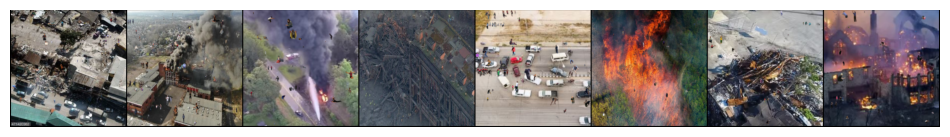

In [52]:
from torchvision.utils import make_grid
train_image_dir = "/mnt/C2A/2/C2A_Dataset/new_dataset3/train/images"
train_label_dir = "/mnt/C2A/2/C2A_Dataset/new_dataset3/train/labels"
transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
)
image_files = [os.path.join(train_image_dir, f) for f in os.listdir(train_image_dir) if f.endswith(".png")]
train_dataset = YOLODataset(image_files=image_files, labels_dir=train_label_dir, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=detection_collate,pin_memory=True)
images, labels = next(iter(train_dataloader))  # 获取训练集第一个批次中的图片及相应标签
print(images.shape)  
# print(labels.shape)  
plt.figure(figsize=(12, 20))  
plt.axis('off')  
plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))  # make_grid函数把多张图片一起显示，permute函数调换channel维的顺序
plt.show()

In [59]:
def print_log(epoch, num_epochs, train_time, train_loss):
    print(f"Epoch [{epoch}/{num_epochs}], time: {train_time:.4f}s, train_loss: {train_loss:.4f}")


def train(
    model: myYOLO,
    dataloader:YOLODataset,
    optimizer: optim.Optimizer,
    device: torch.device,
    num_epochs: int = 10,
):
    """训练函数"""
    model.train()
    for epoch in range(num_epochs):
        start = time.time()
        train_loss = 0 
        for batch_idx, (images, targets) in enumerate(dataloader):
            
            # 制作训练标签
            targets = [label.tolist() for label in targets]
            targets = gt_creator(
                input_size=224,
                stride=model.stride, 
                label_lists=targets
                )
            
            # to device
            images = images.to(device)          
            targets = targets.to(device)

            # 前向传播
            conf_loss, cls_loss, bbox_loss, total_loss = model(images, targets=targets)

            # 计算损失
            train_loss += total_loss.item() 

            # 反向传播, 更新梯度
            optimizer.zero_grad()
            total_loss.backward()

            # 更新模型参数
            optimizer.step()

        train_loss /= len(dataloader)
        end = time.time()
        train_time = end - start
        num_epochs = 10
        print_log(epoch+1, num_epochs, train_time, train_loss)

In [60]:
def main():
    device = torch.device("cuda")

    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
    )

    train_image_dir = "/mnt/C2A/2/C2A_Dataset/new_dataset3/train/images"
    train_label_dir = "/mnt/C2A/2/C2A_Dataset/new_dataset3/train/labels"
    
    image_files = [os.path.join(train_image_dir, f) for f in os.listdir(train_image_dir) if f.endswith(".png")]
    
    train_dataset = YOLODataset(image_files=image_files, labels_dir=train_label_dir, transform=transform)
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=detection_collate,num_workers=4,pin_memory=True)
    
    # 初始化模型
    model = myYOLO().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train(model, train_dataloader, optimizer, device, num_epochs=10)
    
if __name__ == "__main__":
    main()

Epoch [1/10], time: 80.8231s, train_loss: 196.6173
Epoch [2/10], time: 82.2138s, train_loss: 166.2042
Epoch [3/10], time: 79.0217s, train_loss: 160.7428
Epoch [4/10], time: 79.0898s, train_loss: 154.6863
Epoch [5/10], time: 76.5072s, train_loss: 151.4890
Epoch [6/10], time: 77.7468s, train_loss: 143.6692
Epoch [7/10], time: 76.7580s, train_loss: 136.1885
Epoch [8/10], time: 84.9528s, train_loss: 132.7510
Epoch [9/10], time: 78.6324s, train_loss: 129.3757
Epoch [10/10], time: 84.4459s, train_loss: 126.6741
